**TP Filtres de Kalman d'ensemble**

L'objectif de ce TP est la mise en place d'un système d'assimilation de données par filtres de Kalman d'ensemble, pour le système de Lorenz 63 :

$$ \dot{x} = \sigma (y-x) $$
$$ \dot{y} = x (\rho -z ) -y $$
$$ \dot{z} = xy -\beta z $$
Les paramètres par défaut sont $\sigma = 10$, $\rho = 28$, $\beta=8/3$, et la condition initiale $(1.5, -1.5, 21)$. 

*Sources*: ce TP s'inspire des notebooks d'E. Cosme (UGA).


In [1]:
import numpy as np
import math
import scipy as scp
import scipy.sparse as scps
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import scipy

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#-------------------------------------------------------
# Lorenz 63
#-------------------------------------------------------

class Model:

    def __init__( self, nmembers = 1, sigma=10., rho=28., beta=8./3., dt=0.01, x0 = np.array([1.5, -1.5, 20.])):
        self.nmembers = nmembers
        self.nx = 3                     
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.dt = dt
        self.x0 = x0
        self.xvar = self.initial_condition() 
        self.xvar_series = []
        self.time = 0.
        self.time_series = []
        
    def initial_condition(self):
        """Condition initiale"""
        if self.nmembers == 1:
            xout = self.x0.reshape((self.nx, 1))
        else:
            p0 = 3.*np.eye(self.nx)
            xout = np.random.multivariate_normal(self.x0, p0, self.nmembers).T
        return xout

    def rhs(self,x_in):
        """Second membre"""
        x_out=np.zeros_like(x_in)
        x_out[0,]=self.sigma*(x_in[1,]-x_in[0,])
        x_out[1,]=self.rho*x_in[0,]-x_in[1,]-x_in[0,]*x_in[2,]
        x_out[2,]=x_in[0,]*x_in[1,]-self.beta*x_in[2,]
        return x_out

    def forward(self, nstep_in):
        """Intégration temporelle"""
        self.xvar_series = np.zeros((self.nx, nstep_in, self.nmembers))
        self.time_series = np.zeros(nstep_in)
        for it in range(nstep_in):
            self.xvar_series[:,it,:] = self.xvar
            self.time_series[it] = self.time
            k1=self.rhs(self.xvar)*self.dt
            xtmp=self.xvar+0.5*k1
            k2=self.rhs(xtmp)*self.dt
            xtmp=self.xvar+0.5*k2
            k3=self.rhs(xtmp)*self.dt
            xtmp=self.xvar+k2
            k4=self.rhs(xtmp)*self.dt
            self.xvar+=(k1+2*k2+2*k3+k4)/6.
            self.time += self.dt
  
    def plot(self):
        """Affichage"""
        plt.figure(figsize=(12,8))
        for ix in range(self.nx):
            pnum = 311+ix
            plt.subplot(pnum)
            for ie in range(self.nmembers):
                plt.plot(self.time_series[:],self.xvar_series[ix,:,ie],'black',linewidth=1.)
        plt.show()

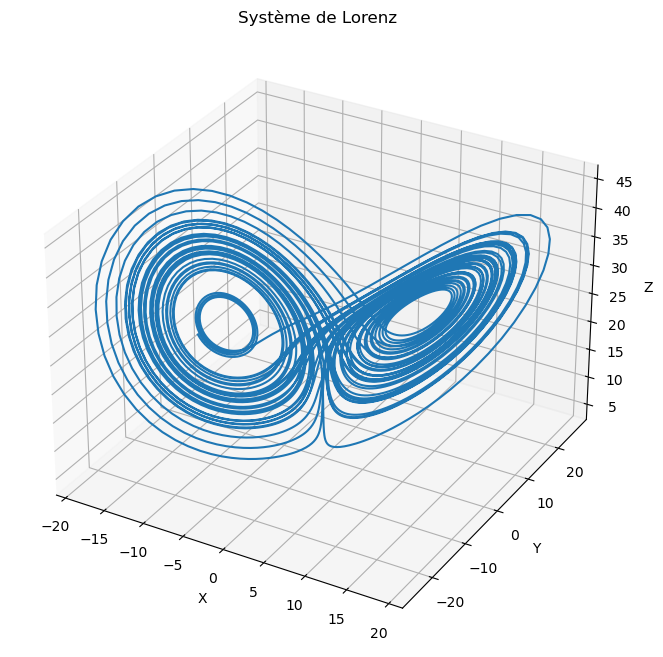

In [3]:
# Illustration du système de Lorenz 63 #

lorenz_test = Model()
lorenz_test.forward(5000)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot(lorenz_test.xvar_series[0,:,0], lorenz_test.xvar_series[1,:,0], lorenz_test.xvar_series[2,:,0])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Système de Lorenz")
plt.show()

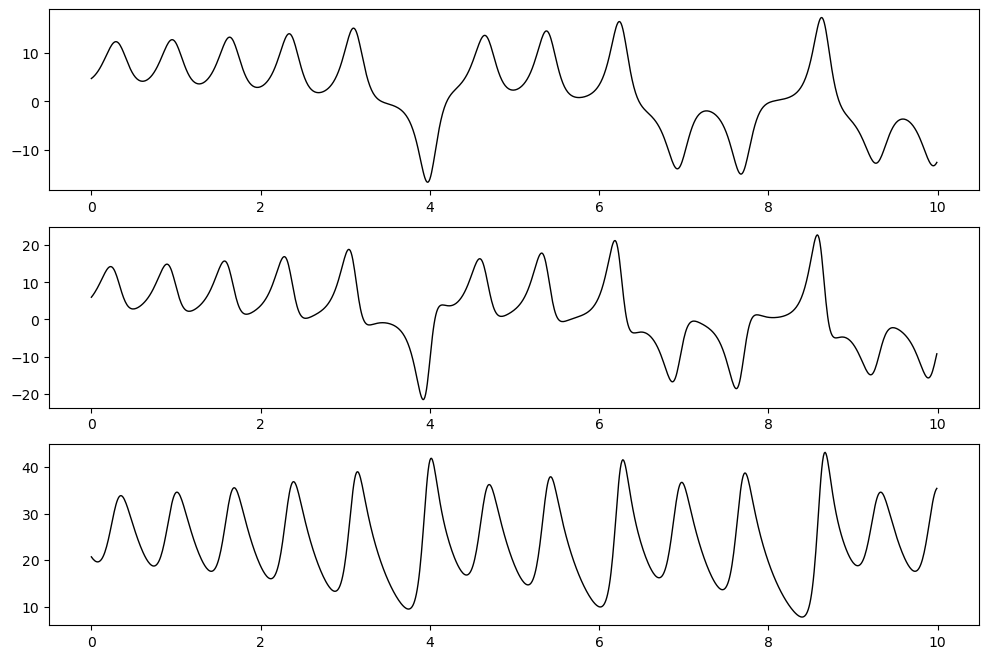

In [37]:
# Simulation de référence
ntime=1000
lorenz_ref = Model()
lorenz_ref.forward(ntime)
lorenz_ref.plot()
true_state = lorenz_ref.xvar_series
true_time = lorenz_ref.time_series

In [38]:
true_state.shape

(3, 1000, 1)

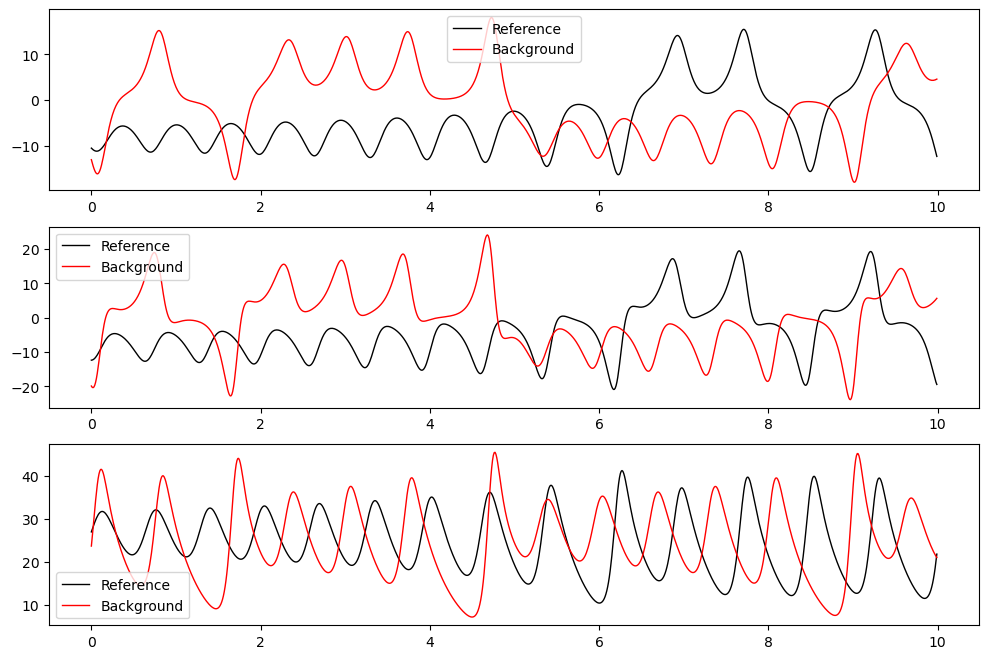

In [5]:
# Ebauche : erreur sur l'état initial et le paramètre rho
background_state = np.array([0.5, -3., 22.])
lorenz_bkg = Model()
lorenz_bkg.rho = 29.
# lorenz_bkg.x0 = np.copy(background_state)
lorenz_bkg.xvar = lorenz_test.initial_condition()
lorenz_bkg.forward(ntime)
plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = 311+ix
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(lorenz_bkg.time_series,lorenz_bkg.xvar_series[ix,:,0],'red',linewidth=1.,label='Background')
    plt.legend()
plt.show()

In [6]:
# Configuration des observations 
nvarobs = [0,2]
nobs = len(nvarobs)
H=np.zeros((nobs,3))
H[0,0]=1.
H[1,2]=1.
assim_steps = range(25,ntime,50)
nassim = len(assim_steps)
lencycle = np.hstack((assim_steps[0], np.ediff1d(assim_steps)))
so2=9.e-2
Robs = so2*np.eye(nobs)

In [7]:
assim_steps

range(25, 1000, 50)

**Analyse par EnKF/ETKF**


On note ${\bf E}^f\in \mathbb{R}^{m\times n}$ l'ensemble de prévision, $\bar{\bf x}^f=\frac{1}{n}{\bf E}^f{\bf e}\in \mathbb{R}^{m}$ sa moyenne, et ${\bf A}^f={\bf E}^f({\bf I}_n-\frac{1}{n}{\bf  e}{\bf  e}^T)\in \mathbb{R}^{m\times n}$, la matrice d'anomalies, avec ${\bf  e}=[1,\dots,1]^T$. 

On souhaite réaliser l'étape d'analyse du filtre de Kalman d'ensemble (EnKF), et de sa variante déterministe (ETKF). Ces deux analyses se décomposent en deux étapes :

1- Mise à jour de la moyenne de l'ensemble :
$$
    \bar{\bf x}^a=\bar{\bf x}^f+ {{\bf A}^f{\bf G}}{\bf R}^{-\frac{1}{2}}({\bf y}-{\bf H}\bar{\bf x}^f)/\sqrt{n-1},
$$

avec ${\bf y}$ le vecteur d'observations, ${\bf H}$ l'opérateur d'observation,
${\bf G}={{\bf S}^T}({\bf I}_p+{{\bf S}}{{\bf S}^T})^{-1}$,
et ${\bf S}={\bf R}^{-\frac{1}{2}}{\bf H}{{\bf A}^f}/\sqrt{n-1}$.


2- Mise à jour de la matrice d'anomalies :
$$
{\bf A}^a={\bf A}^f+ {\bf A}^f {\bf T},
$$
avec ${\bf T}$ définie par :

     a- EnKF :
$${\bf T}={\bf G}({\bf D}-{\bf S}),$$ avec  ${\bf D}={\bf R}^{-\frac{1}{2}}\tilde{\bf D}/\sqrt{n-1}$, $\tilde{\bf D}$ perturbations gaussiennes telles que $\tilde{\bf D}{\bf e}=0$, et $\tilde{\bf D}\tilde{\bf D}^T/(n-1)\rightarrow {\bf R}$.
     
     b- ETKF : 
$${\bf T}=({\bf I}_n+{\bf S}^T{\bf S})^{-\frac{1}{2}}-{\bf I}_n.$$


L'ensemble d'analyse est alors obtenu par $${\bf E}^a={\bf x}^a{\bf e}^T+{\bf A}^a.$$

Plus d'information dans Sakov et al. (2010). 


In [8]:
# Analyse par EnKF ou ETKF #
def analysis(Ef ,y,Robs,H,methode,moderation):
    # Paramètres d'entrée :
    # Ef : ensemble de prévision
    # y : vecteur d'observations
    # Robs : matrice de covariance d'erreur d'observation
    # H : operateur d'observation
    # methode : 1 ETKF, sinon EnKF
    # moderation : paramètres de modération
    #################################
    # Sortie : 
    # Ea : ensemble d'analyse
    Ea=np.zeros_like(Ef)
    
    ### TO DO ###
    m = Ef.shape[0] #3
    n = Ef.shape[1] # nmem
    p = len(y)
    e = np.ones(n)
    x_mean_f = (Ef@e)/n
    A_f = Ef@(np.identity(n) - (e@e.T)/n)
    S = (scipy.linalg.inv(scipy.linalg.sqrtm(Robs))@H@A_f)/np.sqrt(n-1)
    G = (S.T)@np.linalg.inv((np.identity(p) + S@S.T))
    # test = A_f@G@np.linalg.inv(Robs@Robs)@(np.hstack(y) - H@x_mean_f)/np.sqrt(n-1)
    x_mean_a = x_mean_f + A_f@G@scipy.linalg.inv(scipy.linalg.sqrtm(Robs))@(np.hstack(y) - H@x_mean_f)/np.sqrt(n-1)
    

    if methode == 1: #ETFK
        T = scipy.linalg.inv(scipy.linalg.sqrtm((np.identity(n) + (S.T)@S))) - np.identity(n)
    else: #EnKF
        D_tilde = np.random.multivariate_normal(mean=np.zeros(p), cov=Robs, size=n).T
        D = scipy.linalg.inv(scipy.linalg.sqrtm(Robs))@D_tilde/np.sqrt(n-1)
        T = G@(D - S)
        
    A_a = A_f + A_f@T
    Ea = np.outer(x_mean_a,e.T) + A_a
    
    ### END TO DO
    
    return Ea

changer formule on a forcé l'erreur d'obs a être plus forte pour avoir des corrections plus faibles donc prends plus de temps à corriger

In [36]:
lorenz_bkg.xvar_series.shape

(3, 1000, 1)

# Influence d'un paramètre

In [32]:
# Fonction pour calculer le RMSE
def compute_rmse(reference, ensemble):
    """
    Calcule le RMSE entre l'état de référence et la moyenne de l'ensemble.
    """
    ensemble_mean = np.mean(ensemble, axis=2)  # Moyenne sur les membres de l'ensemble
    rmse = np.sqrt(mean_squared_error(reference.flatten(), ensemble_mean.flatten()))
    return rmse
# Étude des hyperparamètres
def hyperparameter_study(true_state, true_time, background_state, params):
    results = []  # Stockage des résultats

    for rho in params['rho']:
        for sigma in params['sigma']:
            for beta in params['beta']:
                for x0 in params['x0']:
                    for nmem in params['nmem']:
                        for ntime in params['ntime']:
                            for step in params['step']:

                                # Initialiser le modèle avec les hyperparamètres
                                lorenz_assim = Model(nmembers=nmem, sigma=sigma, rho=rho, beta=beta)
                                lorenz_assim.x0 = np.copy(x0)
                                lorenz_assim.xvar = lorenz_assim.initial_condition()

                                # Stockage des variances pour EnKF et ETKF
                                variances_enkf = []
                                variances_etkf = []

                                # Cycle d'assimilation EnKF
                                time1_enkf = np.empty(ntime)
                                xvar1_enkf = np.empty((3, ntime, nmem))

                                assim_steps = range(25,ntime,step)

                                for ic in range(len(assim_steps)):
                                    # Prévision
                                    if ic == 0:
                                        nstep = assim_steps[0]
                                    else:
                                        nstep = assim_steps[ic] - assim_steps[ic - 1]

                                    lorenz_assim.forward(nstep)
                                    variance = np.var(lorenz_assim.xvar_series[:,:nstep, :], axis=2)  # Variance par variable
                                    print(variance.shape)
                                    variances_enkf.append(np.mean(variance).shape)  # Moyenne sur toutes les variables et le temps

                                    if ic == 0:
                                        time1_enkf = lorenz_assim.time_series
                                        xvar1_enkf = lorenz_assim.xvar_series
                                    else:
                                        time1_enkf = np.hstack((time1_enkf, lorenz_assim.time_series))
                                        xvar1_enkf = np.concatenate((xvar1_enkf, lorenz_assim.xvar_series), axis=1)

                                    # Analyse (assimilation EnKF)
                                    obs_index = np.argwhere(true_time == lorenz_assim.time)
                                    y = np.transpose(true_state[[0, 2], obs_index, 0] +
                                                     np.dot(np.sqrt(9.e-2) * np.eye(2),
                                                            np.random.normal(0, 1, (2,))))

                                    lorenz_assim.xvar = analysis(lorenz_assim.xvar, y, Robs, H, 0, [])
                                    # print("Ensemble de prévision", lorenz_assim.xvar.shape)
                                    # print("Variance de l'ensemble de prévision", np.var(lorenz_assim.xvar))
                                    # variances_enkf.append(np.var(lorenz_assim.xvar))

                                plt.plot(variances_enkf)
                                print("Moyenne variance",np.mean(variances_enkf))

                                # Dernier cycle de prévision
                                lorenz_assim.forward(ntime - assim_steps[-1])
                                time1_enkf = np.hstack((time1_enkf, lorenz_assim.time_series))
                                xvar1_enkf = np.concatenate((xvar1_enkf, lorenz_assim.xvar_series), axis=1)

                                # Réinitialiser pour ETKF
                                lorenz_assim = Model(nmembers=nmem, sigma=sigma, rho=rho, beta=beta)
                                lorenz_assim.x0 = np.copy(x0)
                                lorenz_assim.xvar = lorenz_assim.initial_condition()

                                # Cycle d'assimilation ETKF
                                time1_etkf = np.empty(ntime)
                                xvar1_etkf = np.empty((3, ntime, nmem))

                                for ic in range(len(assim_steps)):
                                    # Prévision
                                    if ic == 0:
                                        nstep = assim_steps[0]
                                    else:
                                        nstep = assim_steps[ic] - assim_steps[ic - 1]

                                    lorenz_assim.forward(nstep)
                                    variance = np.var(lorenz_assim.xvar_series[:, :nstep, :], axis=2)  # Variance par variable
                                    variances_etkf.append(np.mean(variance))  # Moyenne sur toutes les variables et le temps

                                    if ic == 0:
                                        time1_etkf = lorenz_assim.time_series
                                        xvar1_etkf = lorenz_assim.xvar_series
                                    else:
                                        time1_etkf = np.hstack((time1_etkf, lorenz_assim.time_series))
                                        xvar1_etkf = np.concatenate((xvar1_etkf, lorenz_assim.xvar_series), axis=1)

                                    # Analyse (assimilation ETKF)
                                    obs_index = np.argwhere(true_time == lorenz_assim.time)
                                    y = np.transpose(true_state[[0, 2], obs_index, 0] +
                                                     np.dot(np.sqrt(9.e-2) * np.eye(2),
                                                            np.random.normal(0, 1, (2,))))

                                    lorenz_assim.xvar = analysis(lorenz_assim.xvar, y, Robs, H, 1, [])

                                # Dernier cycle de prévision
                                lorenz_assim.forward(ntime - assim_steps[-1])
                                time1_etkf = np.hstack((time1_etkf, lorenz_assim.time_series))
                                xvar1_etkf = np.concatenate((xvar1_etkf, lorenz_assim.xvar_series), axis=1)

                                # Calcul du RMSE pour les deux méthodes
                                rmse_enkf = compute_rmse(true_state, xvar1_enkf)
                                rmse_etkf = compute_rmse(true_state, xvar1_etkf)

                                mean_variance_enkf = np.mean(variances_enkf)
                                mean_variance_etkf = np.mean(variances_etkf)

                                # Stockage des résultats
                                results.append({
                                    'rho': rho,
                                    'sigma': sigma,
                                    'beta': beta,
                                    'x0': x0,
                                    'nmem': nmem,
                                    'ntime': ntime,
                                    'step': step,
                                    'rmse_enkf': rmse_enkf,
                                    'rmse_etkf': rmse_etkf,
                                    'time1_enkf': time1_enkf,
                                    'xvar1_enkf': xvar1_enkf,
                                    'time1_etkf': time1_etkf,
                                    'xvar1_etkf': xvar1_etkf,
                                    'mean_variance_enkf': mean_variance_enkf,
                                    'mean_variance_etkf': mean_variance_etkf
                                })

    return results

def aggregate_rmse_and_var_by_parameter(param, results):
    """
    Agrège les RMSE pour EnKF et ETKF par valeurs de rho.
    """
    
    # param_values = sorted(list(set(res[param] for res in results)))  # Récupère les valeurs uniques de param
    param_values = [res[param] for res in results]
    rmse_means_enkf = []
    rmse_means_etkf = []
    var_means_etkf = []
    var_means_enkf = []

    # Pour chaque valeur de param, calculer la moyenne des RMSE
    for p in param_values:
        if param=="x0":
            rmse_enkf = [res['rmse_enkf'] for res in results if np.array_equal(res[param], p)]
            rmse_etkf = [res['rmse_etkf'] for res in results if np.array_equal(res[param], p)]
            var_enkf = [res['mean_variance_enkf'] for res in results if np.array_equal(res[param], p)]
            var_etkf = [res['mean_variance_etkf'] for res in results if np.array_equal(res[param], p)]

        else:
            rmse_enkf = [res['rmse_enkf'] for res in results if res[param] == p]
            rmse_etkf = [res['rmse_etkf'] for res in results if res[param] == p]
            var_enkf = [res['mean_variance_enkf'] for res in results if res[param] == p]
            var_etkf = [res['mean_variance_etkf'] for res in results if res[param] == p]

        rmse_means_enkf.append(np.mean(rmse_enkf))  # Moyenne des RMSE EnKF
        rmse_means_etkf.append(np.mean(rmse_etkf))  # Moyenne des RMSE ETKF
        var_means_enkf.append(np.mean(var_enkf))
        var_means_etkf.append(np.mean(var_etkf))

    return param_values, rmse_means_enkf, rmse_means_etkf, var_means_enkf, var_means_etkf

def plot_variance_by_parameter(param, results):
    """
    Visualise la variance moyenne en fonction de l'hyperparamètre spécifié.
    """
    param_values, mean_variances_enkf, mean_variances_etkf = aggregate_rmse_by_parameter(param, results)

    plt.figure(figsize=(10, 6))
    plt.plot(param_values, mean_variances_enkf, label='EnKF Variance', color='red', marker='o')
    plt.plot(param_values, mean_variances_etkf, label='ETKF Variance', color='blue', marker='x')

    plt.xlabel(f'{param}')
    plt.ylabel('Mean Variance of Ensemble')
    plt.title(f'Impact of {param} on Ensemble Variance')
    plt.legend()
    plt.grid()
    plt.show()

In [33]:
# Paramètres d'étude
params = {
    'rho': [29],               # Valeurs de rho
    'sigma': [12],             # Valeurs de sigma
    'beta': [ 9/3],    # Valeurs de beta
    'x0': [np.array([0.5, -3, 22])],  # Conditions initiales
    'nmem': [50],               # Nombre de membres dans l'ensemble,
    'ntime':[1000],
    'step':[25]
    # 'step':[5,25,100]
}

# Appel de la fonction d'étude
results = hyperparameter_study(true_state, true_time, background_state,  params)

# Analyse et visualisation des résultats
for res in results:
    print(f"rho={res['rho']}, sigma={res['sigma']}, beta={res['beta']}, x0={res['x0']}, nmem={res['nmem']} -> RMSE EnKF={res['rmse_enkf']:.4f}, RMSE ETKF={res['rmse_etkf']:.4f}")

    # Visualiser les courbes de l'ensemble moyen et de la référence
    xvarmean_enkf = np.mean(res['xvar1_enkf'], axis=2)  # Moyenne des membres de l'ensemble EnKF
    xvarmean_etkf = np.mean(res['xvar1_etkf'], axis=2)  # Moyenne des membres de l'ensemble ETKF

    plt.figure(figsize=(12, 8))
    for ix in range(3):
        pnum = 311 + ix
        plt.subplot(pnum)
        plt.plot(true_time, true_state[ix, :, 0], 'black', linewidth=1., label='Reference')
        plt.plot(res['time1_enkf'], xvarmean_enkf[ix, :], 'red', linewidth=1., label='EnKF')
        plt.plot(res['time1_etkf'], xvarmean_etkf[ix, :], 'blue', linewidth=1., label='ETKF')
        plt.title(f'Variable {ix + 1}')
        plt.legend()

    plt.suptitle(f"rho={res['rho']}, sigma={res['sigma']}, beta={round(res['beta'], 2)}, x0={res['x0']}, nmem={res['nmem']}, ntime={res['ntime']}, step={res['step']}")
    plt.tight_layout()
    plt.show()

AxisError: axis 2 is out of bounds for array of dimension 2

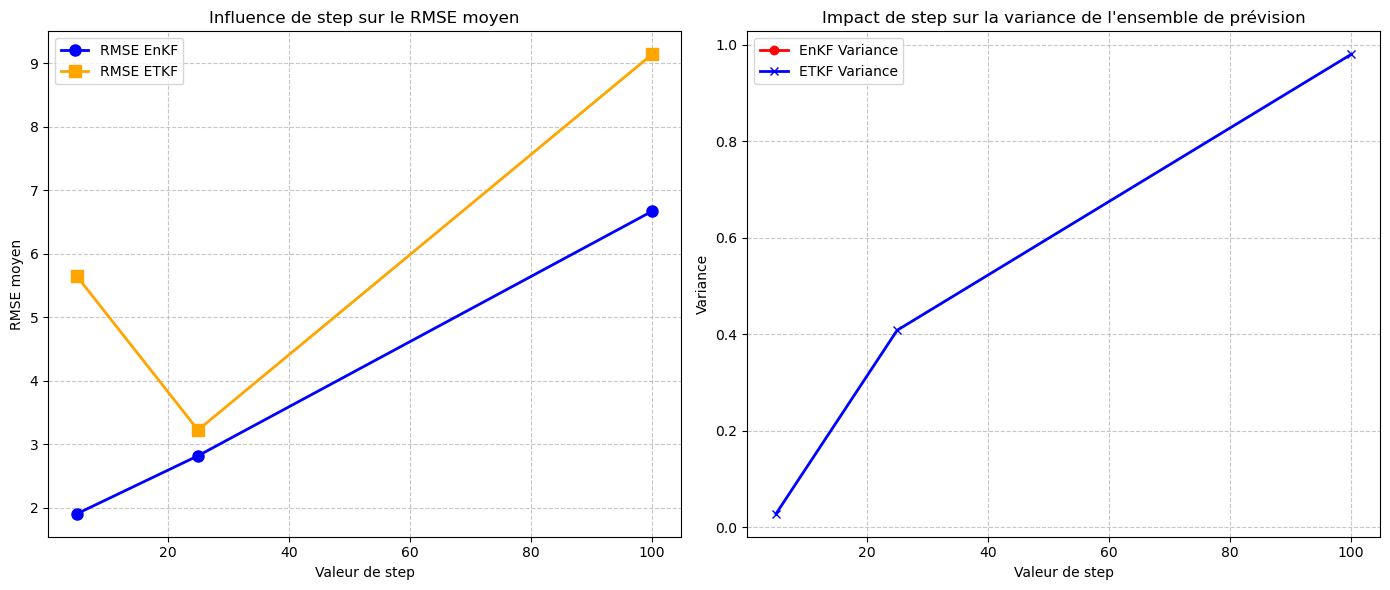

In [15]:
# Appel de la fonction d'agrégation
param= "step"
param_values, rmse_means_enkf, rmse_means_etkf, var_means_enkf, var_means_etkf = aggregate_rmse_and_var_by_parameter(param,results)
# tick_positions = [param[0] for param in param_values]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Graphe RMSE
axes[0].plot(param_values, rmse_means_enkf, 'o-', label='RMSE EnKF', color='blue', linewidth=2, markersize=8)
axes[0].plot(param_values, rmse_means_etkf, 's-', label='RMSE ETKF', color='orange', linewidth=2, markersize=8)
axes[0].set_title(f"Influence de {param} sur le RMSE moyen", fontsize=12)
axes[0].set_xlabel(f"Valeur de {param}", fontsize=10)
axes[0].set_ylabel("RMSE moyen", fontsize=10)
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].legend(fontsize=10)

# 2. Graphe Variance
axes[1].plot(param_values, var_means_enkf, label='EnKF Variance', color='red', marker='o', linewidth=2)
axes[1].plot(param_values, var_means_etkf, label='ETKF Variance', color='blue', marker='x', linewidth=2)
axes[1].set_title(f"Impact de {param} sur la variance de l'ensemble de prévision", fontsize=12)
axes[1].set_xlabel(f"Valeur de {param}", fontsize=10)
axes[1].set_ylabel("Variance", fontsize=10)
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].legend(fontsize=10)

# Ajustement de l'espacement
plt.tight_layout()
plt.show()